# Heart Disease: An In-depth Diagnosis

# Introduction

While we have already shown ways to produce an ML model, it's blackbox nature will be a difficult sell. Input coming in and throwing an output without backup explanation is difficult to convince a client especially in an industry as serious as healthcare. 

In [1]:
!pip install eli5
!pip install shap
!pip install pdpbox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

# The Data

Next, load the data,

In [2]:
# This allows us to drag a csv file to open
# Only for google Colab
from google.colab import files
uploaded = files.upload()
dt = pd.read_csv("./heart_disease.csv")


Saving heart_disease.csv to heart_disease (7).csv


Let's take a look,

In [3]:
dt.head(10)

age  sex   cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1  NaN       145   233    1  ...      0      2.3      0   0     1       1
1   37    1    2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0    1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1    1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0    0       120   354    0  ...      1      0.6      2   0     2       1
5   57    1    0       140   192    0  ...      0      0.4      1   0     1       1
6   56    0    1       140   294    0  ...      0      1.3      1   0     2       1
7   44    1    1       120   263    0  ...      0      0.0      2   0     3       1
8   52    1    2       172   199    1  ...      0      0.5      2   0     3       1
9   57    1    2       150   168    0  ...      0      1.6      2   0     2       1

[10 rows x 14 columns]

It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)
.

A quick google leads to the following as likely indicators of heart disease: **high cholesterol, high blood pressure, diabetes, weight, family history and smoking**. The major factors that can't be changed are: **increasing age, male gender and heredity**. Note that **thalassemia**, one of the variables in this dataset, is heredity. Major factors that can be modified are: **Smoking, high cholesterol, high blood pressure, physical inactivity, and being overweight and having diabetes**. Other factors include **stress, alcohol and poor diet/nutrition**.

Given that the definition of heart disease is **"...what happens when your heart's blood supply is blocked or interrupted by a build-up of fatty substances in the coronary arteries"**, it seems logical the *more* major vessels is a good thing, and therefore will reduce the probability of heart disease.

Given the above, I would hypothesis that, if the model has some predictive ability, these factors standing out as the most important.

In [4]:
dt.head()

age  sex   cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1  NaN       145   233    1  ...      0      2.3      0   0     1       1
1   37    1    2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0    1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1    1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0    0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]

In [5]:
# Check data types
dt.dtypes

age           int64
sex           int64
cp           object
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [0]:
#Fix data types => Turn certain fields into strings
dt['sex'] = dt['sex'].astype('object')
dt['cp'] = dt['cp'].astype('object')
dt['fbs'] = dt['fbs'].astype('object')
dt['restecg'] = dt['restecg'].astype('object')
dt['exang'] = dt['exang'].astype('object')
dt['slope'] = dt['slope'].astype('object')
dt['thal'] = dt['thal'].astype('object')

In [7]:
dt.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

For the categorical varibles, we need to create dummy variables. I'm also going to drop the first category of each. For example, rather than having 'male' and 'female', we'll have 'male' with values of 0 or 1 (1 being male, and 0 therefore being female).

In [0]:
# Turn the objects with 'object' type into separate columns with their values
dt = pd.get_dummies(dt, drop_first=True)

In [9]:
dt.head()

age  trestbps  chol  thalach  ...  slope_2  thal_1  thal_2  thal_3
0   63       145   233      150  ...        0       1       0       0
1   37       130   250      187  ...        0       0       1       0
2   41       130   204      172  ...        1       0       1       0
3   56       120   236      178  ...        1       0       1       0
4   57       120   354      163  ...        1       0       1       0

[5 rows x 21 columns]

# The Model

The next part fits a random forest model to the data,

In [0]:
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.model_selection import train_test_split #for data splitting

X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

In [11]:
# Random forest and set max depth, this also defaults to decision tree classifier to create the splits.
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
estimator = model.estimators_[1]

# Get our feature names
feature_names = [i for i in X_train.columns]

#Properly label y_training
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [13]:
# Graph code stolen from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# Export using graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

# This is actually a bash command
!dot -Tpng tree.dot -o tree_out.png -Gdpi=600

# Display the image from the iPython shell
from IPython.display import Image
Image(filename = 'tree_out.png', width=1000,height=400)


This gives us on explainability tool. However, I can't glance at this and get a quick sense of the most important features. We'll revisit those later. Next, let's evaluate the model,

In [0]:
# Create predictions with model.predict
y_pred_bin = model.predict(X_test)

Assess the fit with a confusion matrix,

In [15]:
# Get accuracy and confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix #for model evaluation

accuracy = accuracy_score(y_test, y_pred_bin)
cmatrix = confusion_matrix(y_test, y_pred_bin)
print("Accuracy: \n", accuracy)
print("Cmatrix: \n", cmatrix)

Accuracy: 
 0.819672131147541
Cmatrix: 
 [[27  8]
 [ 3 23]]


Diagnostic tests are often sold, marketed, cited and used with **sensitivity** and **specificity** as the headline metrics. Sensitivity and specificity are defined as,

\begin{align}
Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives}
\end{align}

\begin{align}
Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives}
\end{align}

Let's see what this model is giving,

In [16]:
# Basic sensitivity analysis
total=sum(sum(cmatrix))

sensitivity = cmatrix[0,0]/(cmatrix[0,0]+cmatrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = cmatrix[1,1]/(cmatrix[1,1]+cmatrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.9
Specificity :  0.7419354838709677


<a id='section4'></a>

# The Explanation

Now let's see what the model gives us from the ML explainability tools.


### Permutation Importance

This tool is useful for understanding which feature is the most important towards constructing a model and it's effect on accuracy.


In [17]:
# Get permutation importance, how each feature affects the model
# Note this changes with different subsets of the data, depending on X_test
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)<br />
exang: Exercise induced angina (1 = yes; 0 = no) <br />
ca: The number of major vessels (0-3) <br />


So, it looks like the most important factors in terms of permutation is a thalessemia result of 'reversable defect'. The high importance of 'max heart rate achieved' type makes sense, as this is the immediate, subjective state of the patient at the time of examination (as opposed to, say, age, which is a much more general factor).

Let's take a closer look at the number of major vessles using a **Partial Dependence Plot** (learn more [here](https://www.kaggle.com/dansbecker/partial-plots)). These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect. Let's take a look at the 'num_major_vessels' variable, which was at the top of the permutation importance list,

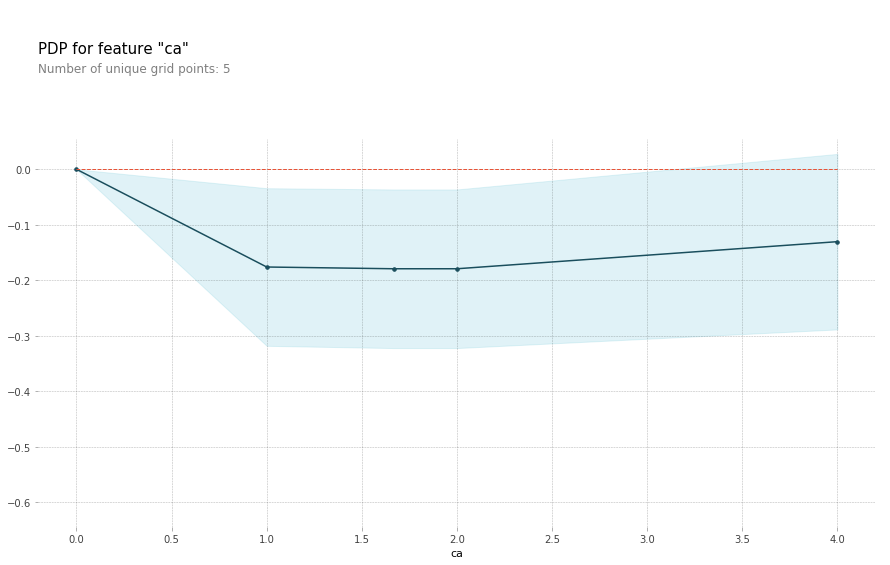

In [18]:
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
# Plot PDP
base_features = dt.columns.values.tolist()
base_features.remove('target')

# Plot new feature
feat_name = 'ca'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

# Show plot
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the number of major blood vessels *increases*, the probability of heart disease *decreases*. That makes sense, as it means more blood can get to the heart.

What about the 'age',

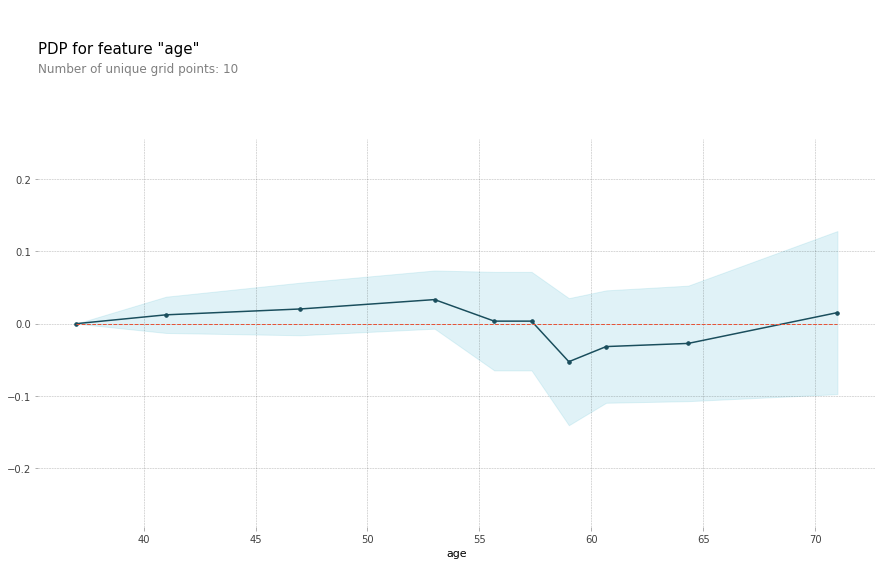

In [19]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

That's a bit odd. The higher the age, the lower the chance of heart disease? Althought the blue confidence regions show that this might not be true (the red baseline is within the blue zone).

What about the 'st_depression',

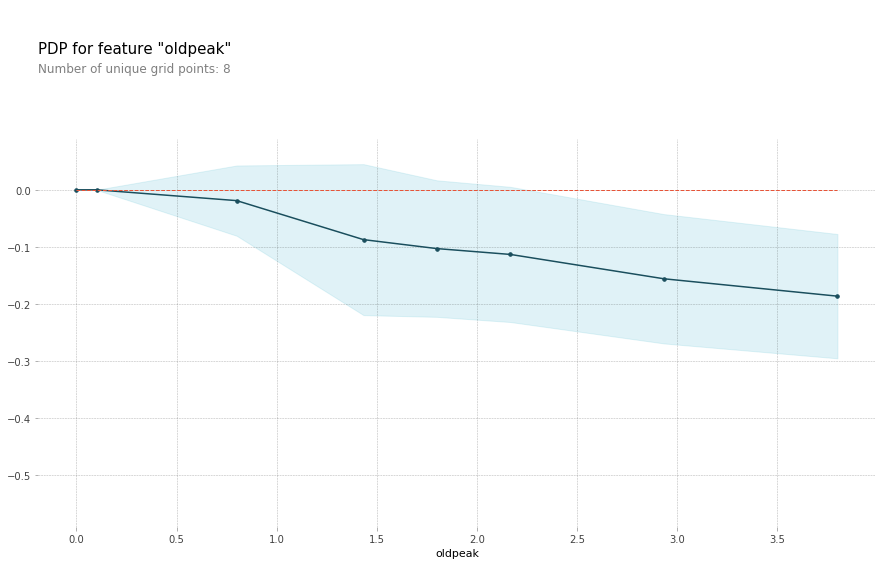

In [20]:
feat_name = 'oldpeak'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Interestingly, this variable also shows a reduction in probability the higher it goes. What exactly is this? A search on Google brought me to the following description by Anthony L. Komaroff, MD, an internal medicine specialist [5](https://www.sharecare.com/health/circulatory-system-health/what-st-segment-electrocardiogram-ecg) .... *"An electrocardiogram (ECG) measures the heart's electrical activity. The waves that appear on it are labeled P, QRS, and T. Each corresponds to a different part of the heartbeat. The **ST segment** represents the heart's electrical activity immediately after the right and left ventricles have contracted, pumping blood to the lungs and the rest of the body. Following this big effort, ventricular muscle cells relax and get ready for the next contraction. During this period, little or no electricity is flowing, so the ST segment is even with the baseline or sometimes slightly above it. The faster the heart is beating during an ECG, the shorter all of the waves become. **The shape and direction of the ST segment are far more important than its length. Upward or downward shifts can represent decreased blood flow to the heart from a variety of causes, including heart attack, spasms in one or more coronary arteries (Prinzmetal's angina), infection of the lining of the heart (pericarditis) or the heart muscle itself (myocarditis), an excess of potassium in the bloodstream, a heart rhythm problem, or a blood clot in the lungs (pulmonary embolism)."***

<img style="float: left;" src="https://www.cvphysiology.com/uploads/images/CAD012%20ST%20elevation.png" width="350px"/>    [6](https://www.cvphysiology.com/CAD/CAD012)

So, this variable, which is described as 'ST depression induced by exercise relative to rest', seems to suggest the higher the value the higher the probability of heart disease, but the plot above shows the opposite. Perhaps it's not just the depression amount that's important, but the interaction with the slope type? Let's check with a 2D PDP,

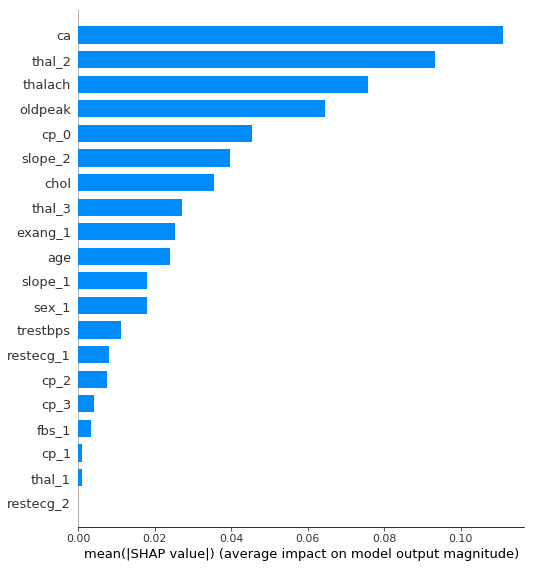

In [21]:
# Create explainer
explainer = shap.TreeExplainer(model)

# Get SHAP_values
shap_values = explainer.shap_values(X_test)

# Plot SHAP_Valuesfeat
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

The number of major vessels is at the top. Let's use a summary plot of the SHAP values,

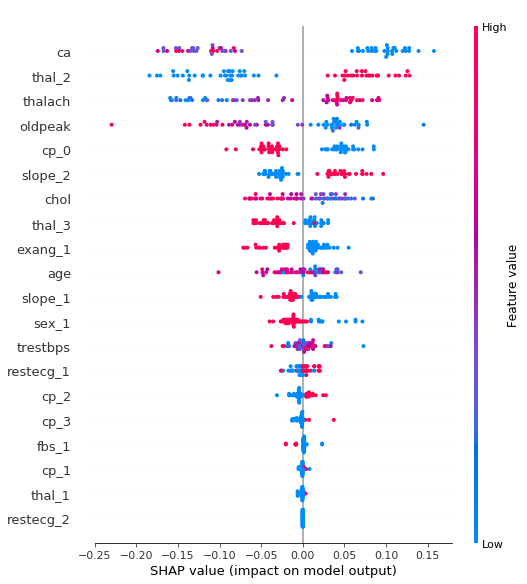

In [22]:
# Use summary plot module
shap.summary_plot(shap_values[1], X_test)

The number of major vessels division is pretty clear, and it's saying that low values are bad (blue on the right). The thalassemia 'reversable defect' division is very clear (yes = red = good, no = blue = bad).

You can see some clear separation in many of the other variables. Exercise induced angina has a clear separation, although not as expected, as 'no' (blue) *increases* the probability. Another clear one is the st_slope. It looks like when it's flat, that's a bad sign (red on the right).

It's also odd is that the men (red) have a *reduced* chance of heart disease in this model. Why is this? Domain knowledge tells us that men have a greater chance.

Next, let's pick out individual patients and see how the different variables are affecting their outcomes,

### Introducing, SHAP - (SHapley Additive exPlanations)

In [0]:
def heart_disease_risk_factors(model, patient):
    # Initialize our explainer with our model
    explainer = shap.TreeExplainer(model)
    
    # Put in the characteristics for our patient
    shap_values = explainer.shap_values(patient)
    
    # Create shap
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [24]:
# The data
data_for_prediction = X_test.iloc[1,:].astype(float)

# Call our SHAP 
heart_disease_risk_factors(model, data_for_prediction)

^ This patient should be alright

For this person, their prediction is 36% (compared to a baseline of 58.4%). Many things are working in their favour, including having a major vessel, a reversible thalassemia defect, and *not* having a flat st_slope.

Let's check another,

In [25]:
# Create our data
data_for_prediction = X_test.iloc[3,:].astype(float)

# Predict our data
heart_disease_risk_factors(model, data_for_prediction)

^ This patient is screwed

For this person, their prediction is 70% (compared to a baseline of 58.4%). Not working in their favour are things like having no major vessels, a flat st_slope, and not a reversible thalassemia defect.

In [26]:
X_test.head()

age  trestbps  chol  thalach  ...  slope_2  thal_1  thal_2  thal_3
246   56       134   409      150  ...        0       0       0       1
183   58       112   230      165  ...        0       0       0       1
229   64       125   309      131  ...        0       0       0       1
126   47       112   204      143  ...        1       0       1       0
184   50       150   243      128  ...        0       0       0       1

[5 rows x 20 columns]

<a id='section5'></a>

# Conclusion

This dataset is old and small by today's standards. However, it's allowed us to create a simple model and then use various machine learning explainability tools and techniques to peek inside. For industries as critical as healthcare, this sort of approach will have ever more importance as understanding why the model works is a requirement for doctors and other healthcare professionals.